In [92]:
# Modues to be used
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import plot_roc_curve


from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier



# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# # The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="";  
 
# Do other imports now...
# import keras

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Load data from pickle files

# -> Player dictionary with the dataFrames
f = open('../data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('../data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('../data/dict_map.pickle','rb')
dict_map = pickle.load(f)

# Create the Data Set

In [25]:
DAYS_WEIGHT = 365

time_1 = datetime.now()

# If we want matches only between only ranked teams
df_tmp = df_map[ (df_map['date']>datetime(2019,1,1)) &
    ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) ) ]


df_two_year = df_map[ (df_map['date']>datetime(2018,1,1)) ]


dict_train = {}

print( len( df_tmp['map_id']) )

#2000 -> ~4min
for map_id in df_tmp['map_id'][:]:

    map_date = df_tmp.loc[map_id]['date']

    dict_train[map_id] = {}    

    # Here we are taking the rankings to be non-zero
    rank_1 = df_tmp.loc[map_id]['team_rank_1']
    rank_2 = df_tmp.loc[map_id]['team_rank_2']

    team_id_1 = df_tmp.loc[map_id]['team_id_1']
    team_id_2 = df_tmp.loc[map_id]['team_id_2']

    # # History between the two teams
    df_history = df_two_year[ 
        (df_two_year['date'] < map_date) &
        (((df_two_year['team_id_1']==team_id_1) & (df_two_year['team_id_2']==team_id_2)) | 
        ((df_two_year['team_id_2']==team_id_1) & (df_two_year['team_id_1']==team_id_2))) ]

    # Here we take the history against teams that are in a similar rank to that of the opponent
    # df_history_1 = df_two_year[ 
    #     (df_two_year['date'] < map_date) & (
    #     ((df_two_year['team_id_1']==team_id_1) & (df_two_year['team_rank_2']>(rank_2-10)) & (df_two_year['team_rank_2']<(rank_2+10)) ) | 
    #     ((df_two_year['team_id_2']==team_id_1) & (df_two_year['team_rank_1']>(rank_2-10)) & (df_two_year['team_rank_1']<(rank_2+10)) ) 
    #     ) ]

    win_vec_1 = (df_two_year[
        (df_two_year['date'] < map_date) &
        (df_two_year['team_id_1']==team_id_1) & 
        (df_two_year['team_rank_2']>(rank_2-10)) & 
        (df_two_year['team_rank_2']<(rank_2+10)) ]['winner'].values == 1)*1

    np.append( win_vec_1, 
        (df_two_year[
            (df_two_year['date'] < map_date) &
            (df_two_year['team_id_2']==team_id_1) & 
            (df_two_year['team_rank_1']>(rank_2-10)) & 
            (df_two_year['team_rank_1']<(rank_2+10)) ]['winner'].values == 2)*1
        )

    if len(win_vec_1) > 0:
        win_rate_1 = np.mean(win_vec_1) - 0.5
    else:
        win_rate_1 = 0.0
    

    win_vec_2 = (df_two_year[
        (df_two_year['date'] < map_date) &
        (df_two_year['team_id_1']==team_id_2) & 
        (df_two_year['team_rank_2']>(rank_1-10)) & 
        (df_two_year['team_rank_2']<(rank_1+10)) ]['winner'].values == 1)*1

    np.append( win_vec_2, 
        (df_two_year[
            (df_two_year['date'] < map_date) &
            (df_two_year['team_id_2']==team_id_2) & 
            (df_two_year['team_rank_1']>(rank_1-10)) & 
            (df_two_year['team_rank_1']<(rank_1+10)) ]['winner'].values == 2)*1
        )

    if len(win_vec_2) > 0:
        win_rate_2 = np.mean(win_vec_2) - 0.5
    else:
        win_rate_2 = 0.0
    
   
    # We get the scores for the matches between the two teams
    score_history_1 = df_history[ 
        (df_history['team_id_1']==team_id_1) ]['team_score_1'].values
    
    np.append( score_history_1, df_history[ 
        (df_history['team_id_2']==team_id_1) ]['team_score_2'].values )

    score_history_2 = df_history[ 
        (df_history['team_id_2']==team_id_2) ]['team_score_2'].values
    
    np.append( score_history_2, df_history[ 
        (df_history['team_id_1']==team_id_2) ]['team_score_1'].values )

    winner = df_tmp.loc[map_id]['winner']

    if rank_1 < rank_2:
        fav = 0
        dict_train[map_id]['rank_dif'] = rank_2-rank_1

        if len(score_history_1) > 0:
            dict_train[map_id]['history_dif'] = np.mean( score_history_1-score_history_2 )
        else:
            dict_train[map_id]['history_dif'] = 0.0

        dict_train[map_id]['shift_win_rate_0'] = win_rate_1
        dict_train[map_id]['shift_win_rate_1'] = win_rate_2

        if winner == 1:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    else:
        fav = 1
        dict_train[map_id]['rank_dif'] = rank_1-rank_2

        if len(score_history_1) > 0:
            dict_train[map_id]['history_dif'] = np.mean( score_history_2-score_history_1 )
        else:
            dict_train[map_id]['history_dif'] = 0.0

        dict_train[map_id]['shift_win_rate_0'] = win_rate_2
        dict_train[map_id]['shift_win_rate_1'] = win_rate_1

        if winner == 2:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    count_team = -1
    for team_id in dict_map[map_id]:

        count_team = count_team + 1
        weighted_rating    = []

        weighted_kast      = []
        weighted_kpr       = []
        weighted_round_dif = []

        prize = []

        for player_id in dict_map[map_id][team_id]['players_id']:            

            df_aux = dict_player[player_id]

            date_vec = (map_date-df_aux['date']).astype('timedelta64[D]')

            df_aux = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            try:
                m = float(1.0)/ sum( date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)]-DAYS_WEIGHT )
            except:
                m = 0.0

            w_i = m * (date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)] - DAYS_WEIGHT)
            
            # w_i = 1.0

            weighted_rating.append( sum(df_aux['rating'] * w_i) )
            prize.append( df_aux['prize'].sum() )

            weighted_kast.append( sum(df_aux['KAST'] * w_i / 100.0) )
            weighted_kpr.append( sum(df_aux['kills_per_round'] * w_i) )
            
            weighted_round_dif.append( sum( (df_aux['team_score']-df_aux['op_score']) * w_i) )

        order = np.argsort( weighted_rating )

        if count_team == fav:
            count_p = -1
            for ind in order:
                count_p = count_p + 1
                dict_train[map_id]['t_0_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
                dict_train[map_id]['t_0_p_'+str(count_p)+'_kast']   = weighted_kast[ind]
                dict_train[map_id]['t_0_p_'+str(count_p)+'_kpr']    = weighted_kpr[ind]
        else:
            count_p = -1
            for ind in order:
                count_p = count_p + 1
                dict_train[map_id]['t_1_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
                dict_train[map_id]['t_1_p_'+str(count_p)+'_kast']   = weighted_kast[ind]
                dict_train[map_id]['t_1_p_'+str(count_p)+'_kpr']    = weighted_kpr[ind]

        if count_team == fav:

            dict_train[map_id]['t0_prize'] = np.average( prize )
            dict_train[map_id]['t_0_avg_rating'] = np.average( weighted_rating )
            
        else:

            dict_train[map_id]['t1_prize'] = np.average( prize )
            dict_train[map_id]['t_1_avg_rating'] = np.average( weighted_rating )
            
    

time_2 = datetime.now()

print( time_2-time_1 )
#date_vec

10466
0:13:15.329551


In [171]:
# dict_train_1000 = dict_train
# dict_train = dict_train_1000

# Here we process the results we got

In [29]:

df_train = pd.DataFrame.from_dict(dict_train,orient='index')

for map_id in df_train.index:
    df_train.at[map_id,'rating_dif'] = (dict_train[map_id]['t_0_avg_rating'] - dict_train[map_id]['t_1_avg_rating'])

    if dict_train[map_id]['t0_prize'] > 0:
        dict_train[map_id]['t0_prize_rating'] = np.log(dict_train[map_id]['t0_prize']) / 12.0
    else:
        dict_train[map_id]['t0_prize_rating'] = 0.0

    if dict_train[map_id]['t1_prize'] > 0:
        dict_train[map_id]['t1_prize_rating'] = np.log(dict_train[map_id]['t1_prize']) / 12.0
    else:
        dict_train[map_id]['t1_prize_rating'] = 0.0


    df_train.at[map_id,'prize_rating_dif'] = dict_train[map_id]['t0_prize_rating'] - dict_train[map_id]['t1_prize_rating'] 
    #df_train.at[map_id,'kast_dif'] = 1.0*(dict_train[map_id]['t_0_avg_kast'] - dict_train[map_id]['t_1_avg_kast'])**1
    #df_train.at[map_id,'rank_rating'] = df_train.at[map_id,'t_1_avg_rating'] / df_train.at[map_id,'rank_dif']


df_train = df_train.fillna(0)

print(df_train.keys())

print(df_train['fav_win'].mean())

df_train.tail(n=80)

Index(['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
       'fav_win', 't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
       't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
       't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
       't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
       't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
       't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
       't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
       't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
       't1_prize_rating', 'rating_dif', 'prize_rating_dif'],
      dtype='object')
0.6120772023695776


,rank_dif,history_dif,shift_win_rate_0,shift_win_rate_1,fav_win,t_0_p_0_rating,t_0_p_0_kast,t_0_p_0_kpr,t_0_p_1_rating,t_0_p_1_kast,...,t_1_p_3_kpr,t_1_p_4_rating,t_1_p_4_kast,t_1_p_4_kpr,t1_prize,t_1_avg_rating,t0_prize_rating,t1_prize_rating,rating_dif,prize_rating_dif
97490,35,0.000000,0.333333,0.000000,0,0.887377,0.700721,0.504587,1.131950,0.714987,...,0.728919,1.198690,0.726475,0.779016,4796.000000,1.141178,0.821111,0.706295,-0.014313,0.114816
97491,13,1.333333,-0.166667,0.147059,1,0.601734,0.592671,0.401492,1.006376,0.706457,...,0.745683,1.202916,0.724148,0.776850,7939.666667,1.123462,0.565031,0.748302,-0.131812,-0.183271
97492,4,0.000000,-0.166667,0.045455,0,0.906742,0.650891,0.576703,0.956502,0.695821,...,0.720652,1.209032,0.721735,0.781393,18520.433333,1.087940,0.787988,0.818886,-0.039003,-0.030898
97493,35,0.000000,0.333333,0.000000,1,0.887377,0.700721,0.504587,1.131950,0.714987,...,0.728919,1.198690,0.726475,0.779016,4796.000000,1.141178,0.821111,0.706295,-0.014313,0.114816
97494,4,0.000000,-0.166667,0.045455,0,0.906742,0.650891,0.576703,0.956502,0.695821,...,0.720652,1.209032,0.721735,0.781393,18520.433333,1.087940,0.787988,0.818886,-0.039003,-0.030898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97582,10,0.000000,0.125000,0.500000,1,1.055105,0.711457,0.643705,1.075219,0.709337,...,0.765130,1.204292,0.714838,0.778549,49486.633333,1.113044,0.936912,0.900788,0.022110,0.036124
97586,10,0.000000,0.125000,0.500000,1,1.055105,0.711457,0.643705,1.075219,0.709337,...,0.765130,1.204292,0.714838,0.778549,49486.633333,1.113044,0.936912,0.900788,0.022110,0.036124
97591,4,2.600000,0.041667,-0.156250,1,0.985143,0.691115,0.608951,1.086184,0.710155,...,0.760154,1.206726,0.752201,0.762189,10793.333333,1.143090,0.903652,0.773890,-0.042573,0.129761
97593,4,2.600000,0.041667,-0.156250,0,0.985143,0.691115,0.608951,1.086184,0.710155,...,0.760154,1.206726,0.752201,0.762189,10793.333333,1.143090,0.903652,0.773890,-0.042573,0.129761


# Now the Logistic regression model

In [9]:
df_tmp.head(n=50)

,map_id,map,date,event_id,event_name,team_id_1,team_name_1,team_score_1,team_kills_1,team_deaths_1,team_assists_1,team_rank_1,team_id_2,team_name_2,team_score_2,team_kills_2,team_deaths_2,team_assists_2,team_rank_2,winner
79922,79922,inf,2019-01-04 15:00:00,4273,Pixel.bet Brawl: Nordic vs. Europe,8248,PACT,11,79.0,87.0,10.0,77,8846,x-kom,16,86.0,79.0,23.0,86,2
79923,79923,mrg,2019-01-04 15:00:00,4273,Pixel.bet Brawl: Nordic vs. Europe,8248,PACT,9,71.0,98.0,16.0,77,8846,x-kom,16,98.0,71.0,13.0,86,2
79943,79943,ovp,2019-01-05 17:20:00,4343,ESL Premiership Winter 2018 Finals,9674,London,14,98.0,108.0,19.0,152,7234,Endpoint,16,108.0,99.0,18.0,72,2
79945,79945,inf,2019-01-05 17:20:00,4343,ESL Premiership Winter 2018 Finals,9674,London,16,84.0,68.0,15.0,152,7234,Endpoint,8,68.0,84.0,15.0,72,1
79947,79947,mrg,2019-01-05 17:20:00,4343,ESL Premiership Winter 2018 Finals,9674,London,16,89.0,66.0,21.0,152,7234,Endpoint,7,66.0,89.0,18.0,72,1
79959,79959,inf,2019-01-07 17:00:00,4243,United Masters League,8068,AGO,16,96.0,52.0,20.0,33,9393,expert,6,52.0,96.0,10.0,73,1
79962,79962,trn,2019-01-07 17:00:00,4243,United Masters League,8068,AGO,16,95.0,83.0,18.0,33,9393,expert,13,83.0,95.0,14.0,73,1
79968,79968,inf,2019-01-08 12:30:00,4344,Hunt Wave League,6094,Vega Squadron,19,125.0,110.0,19.0,22,7606,ViCi,16,110.0,125.0,19.0,55,1
79971,79971,inf,2019-01-08 15:35:00,4344,Hunt Wave League,9085,Chaos,16,102.0,80.0,20.0,75,8846,x-kom,11,80.0,102.0,16.0,61,1
79972,79972,inf,2019-01-08 15:00:00,4243,United Masters League,4914,3DMAX,10,81.0,96.0,15.0,46,9393,expert,16,96.0,81.0,19.0,73,2


In [7]:
# Keep only the features that we want
# ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        'fav_win', 't0_prize', 't_0_avg_rating', 't1_prize', 't_1_avg_rating',
#        't0_prize_rating', 't1_prize_rating', 'rating_dif', 'prize_rating_dif']

# Drop all except prize_Rating_dif and rating_dif
# df_tmp = df_train.drop( ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )

# # Drop all except prize_Rating_dif and rating_dif and rank_dif
# df_tmp = df_train.drop( ['history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )


df_tmp = df_train.drop(
    ['rank_dif', 'history_dif', 
       't_0_p_0_kast', 't_0_p_0_kpr',
       't_0_p_1_kast', 't_0_p_1_kpr', 
       't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_kast',
       't_0_p_3_kpr', 't_0_p_4_kast', 't_0_p_4_kpr',
       't0_prize',  't_1_p_0_kast',
       't_1_p_0_kpr',  't_1_p_1_kast', 't_1_p_1_kpr',
        't_1_p_2_kast', 't_1_p_2_kpr', 
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_kast',
       't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't_1_avg_rating', 't0_prize_rating',
       't1_prize_rating' ],axis=1)

#df_tmp = df_train.drop([ 't0_prize', 't1_prize'],axis=1)

# Drop nothing
#df_tmp = df_train.drop(['rank_dif','t0_prize', 't1_prize','rating_dif','prize_rating_dif','t_1_avg_rating'],axis=1)

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fav_win','rank_dif'],axis=1),df_train['fav_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1

#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
print(accuracy)

y_scores = logmodel.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_scores)

>               precision    recall  f1-score   support

Underdog wins       0.69      0.47      0.56        19
Favorite wins       0.73      0.87      0.79        31

     accuracy                           0.72        50
    macro avg       0.71      0.67      0.68        50
 weighted avg       0.72      0.72      0.71        50

[[ 9 10]
 [ 4 27]]
0.72


0.7088285229202037

# All models at once

--------------------------------------------------------------
Logistic

>               precision    recall  f1-score   support

Underdog wins       0.58      0.20      0.29      1027
Favorite wins       0.64      0.91      0.75      1590

     accuracy                           0.63      2617
    macro avg       0.61      0.55      0.52      2617
 weighted avg       0.61      0.63      0.57      2617

[[ 201  826]
 [ 145 1445]]
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.58      0.27      0.37      1027
Favorite wins       0.65      0.87      0.75      1590

     accuracy                           0.64      2617
    macro avg       0.61      0.57      0.56      2617
 weighted avg       0.62      0.64      0.60      2617

[[ 276  751]
 [ 200 1390]]
--------------------------------------------------------------
Random Forest

>               precision    recall  f1-score   support

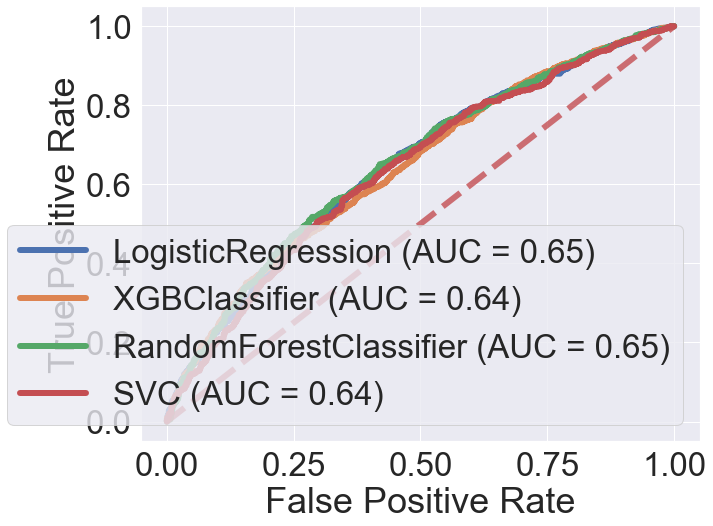

In [93]:
# Keep only the features that we want
# ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        'fav_win', 't0_prize', 't_0_avg_rating', 't1_prize', 't_1_avg_rating',
#        't0_prize_rating', 't1_prize_rating', 'rating_dif', 'prize_rating_dif']

# Drop all except prize_Rating_dif and rating_dif
# df_tmp = df_train.drop( ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )

# # Drop all except prize_Rating_dif and rating_dif and rank_dif
# df_tmp = df_train.drop( ['history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )


df_tmp = df_train.drop(
    ['rank_dif', 'history_dif', 
       't_0_p_0_kast', 't_0_p_0_kpr',
       't_0_p_1_kast', 't_0_p_1_kpr', 
       't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_kast',
       't_0_p_3_kpr', 't_0_p_4_kast', 't_0_p_4_kpr',
       't0_prize',  't_1_p_0_kast',
       't_1_p_0_kpr',  't_1_p_1_kast', 't_1_p_1_kpr',
        't_1_p_2_kast', 't_1_p_2_kpr', 
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_kast',
       't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't_1_avg_rating', 't0_prize_rating',
       't1_prize_rating' ],axis=1)

#df_tmp = df_train.drop([ 't0_prize', 't1_prize'],axis=1)

# Drop nothing
#df_tmp = df_train.drop(['rank_dif','t0_prize', 't1_prize','rating_dif','prize_rating_dif','t_1_avg_rating'],axis=1)

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fav_win','rank_dif'],axis=1),df_train['fav_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('--------------------------------------------------------------')
print('Logistic')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1

#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

# accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
# print(accuracy)

# y_scores = logmodel.predict_proba(X_test)[:,1]

# roc_auc_score(y_test, y_scores)


# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# c_mat = confusion_matrix(y_test, predictions)
# print( c_mat )

print('--------------------------------------------------------------')
print('XGBoost')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )




# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

clf = RandomForestClassifier(n_estimators=20,max_depth=10, random_state=1,bootstrap=True)
clf.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf.predict(X_test)

print('--------------------------------------------------------------')
print('Random Forest')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )


# SVM
clf_svm = svm.SVC(probability=True)
clf_svm.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf_svm.predict(X_test)

print('--------------------------------------------------------------')
print('Support Vector Machines')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )



# AUC ROC
sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(10,8));
ax = plt.axes()
plot_roc_curve(logmodel, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf_svm, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.show()

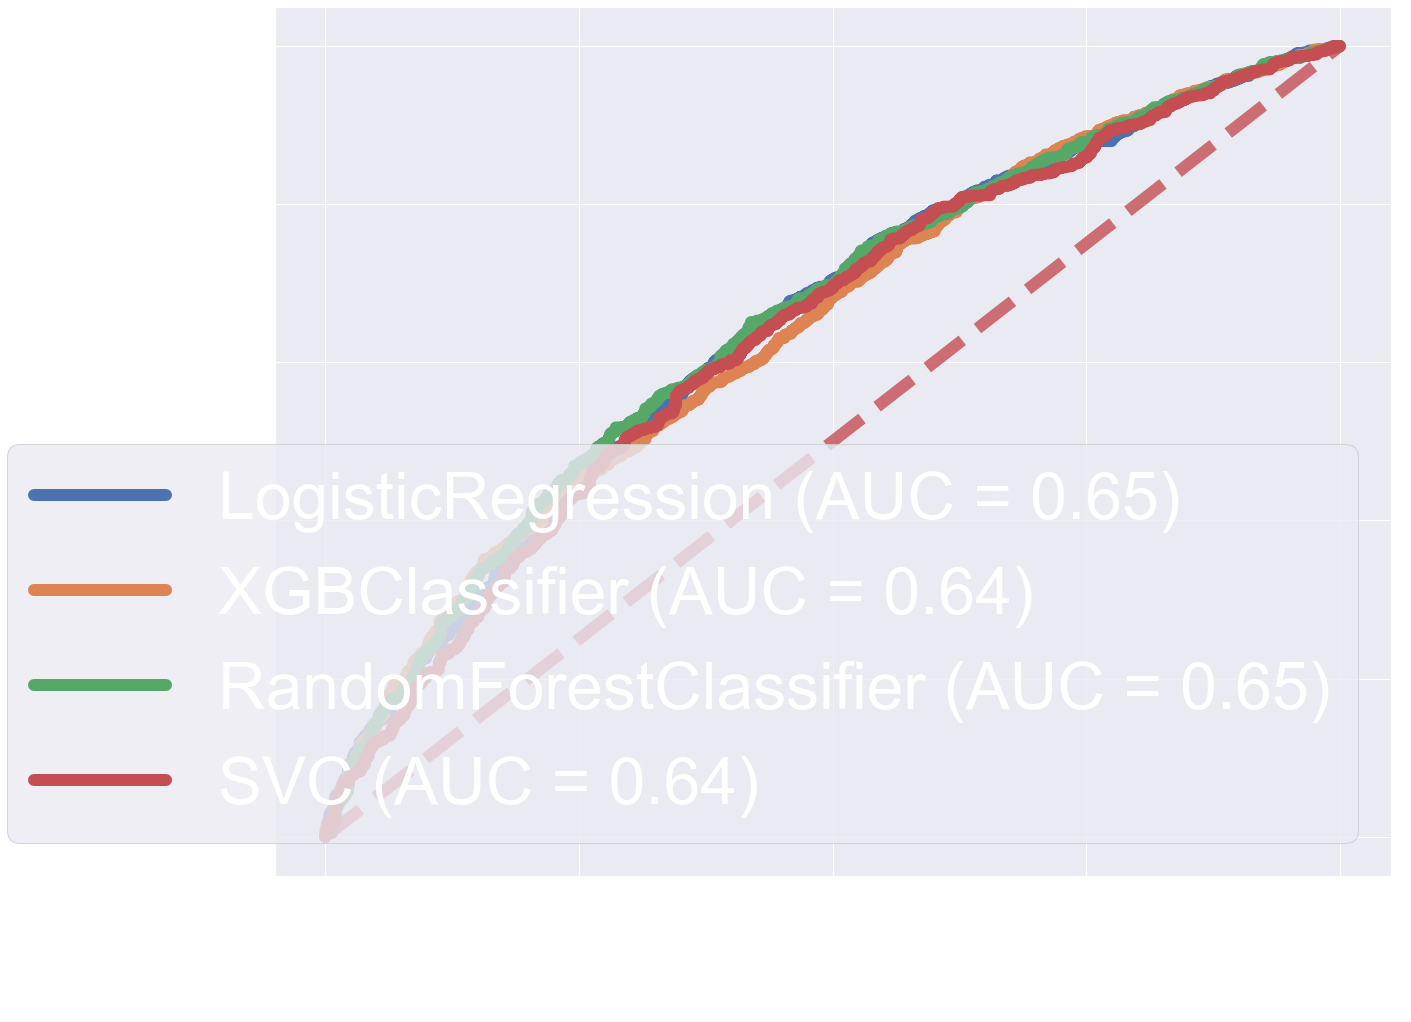

In [98]:
# AUC ROC
sns.set_style("whitegrid")
sns.set(font_scale=6)

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

# mpl.rcParams.update({'text.color' : "black",
#                      'axes.labelcolor' : "black",
#                      'xtick.color' : "black",
#                      'ytick.color' : "black"})

fig = plt.figure(figsize=(20,16))
ax = plt.axes()
plot_roc_curve(logmodel, X_test, y_test, ax=ax, lw=12)  # doctest: +SKIP

plot_roc_curve(model, X_test, y_test, ax=ax, lw=12)  # doctest: +SKIP

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=12)  # doctest: +SKIP

plot_roc_curve(clf_svm, X_test, y_test, ax=ax, lw=12)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=12, color='r',
        label='Chance', alpha=.8 )

plt.savefig('ROC_AUX.svg', transparent=True)
plt.show()



In [51]:
df_tmp.drop(['fav_win'],axis=1).head()

,shift_win_rate_0,shift_win_rate_1,t_0_p_0_rating,t_0_p_1_rating,t_0_p_2_rating,t_0_p_3_rating,t_0_p_4_rating,t_0_avg_rating,t_1_p_0_rating,t_1_p_1_rating,t_1_p_2_rating,t_1_p_3_rating,t_1_p_4_rating,rating_dif,prize_rating_dif
79922,0.0,0.1,0.960763,1.036382,1.058126,1.083756,1.140000,1.055806,1.015623,1.087789,1.089880,1.100734,1.101246,-0.023249,-0.090267
79923,0.0,0.1,0.960763,1.036382,1.058126,1.083756,1.140000,1.055806,1.015623,1.087789,1.089880,1.100734,1.101246,-0.023249,-0.090267
79943,0.0,0.0,0.986605,1.092420,1.109813,1.112223,1.193056,1.098823,1.037230,1.040386,1.087076,1.107534,1.133120,0.017754,0.113935
79945,0.0,0.0,0.986605,1.092420,1.109813,1.112223,1.193056,1.098823,1.037230,1.040386,1.087076,1.107534,1.133120,0.017754,0.113935
79947,0.0,0.0,0.986605,1.092420,1.109813,1.112223,1.193056,1.098823,1.037230,1.040386,1.087076,1.107534,1.133120,0.017754,0.113935


In [87]:
logmodel.coef_[0,:]
#X_train.shape[1]
#importances
#indices

array([ 0.58461577, -0.36558101,  0.43711371,  0.43338096,  1.52727911,
        0.39786447,  0.37165631,  0.63345891, -0.76963473, -0.66798412,
       -0.45886927, -0.14767497, -0.11139367,  1.06457027,  1.83900361])

Feature ranking:
1. feature 14 (0.129241)
2. feature 13 (0.096015)
3. feature 7 (0.072410)
4. feature 4 (0.067588)
5. feature 9 (0.065742)
6. feature 8 (0.063949)
7. feature 0 (0.060785)
8. feature 5 (0.060343)
9. feature 2 (0.059085)
10. feature 12 (0.058568)
11. feature 6 (0.058372)
12. feature 3 (0.058060)
13. feature 11 (0.053896)
14. feature 10 (0.050819)
15. feature 1 (0.045127)


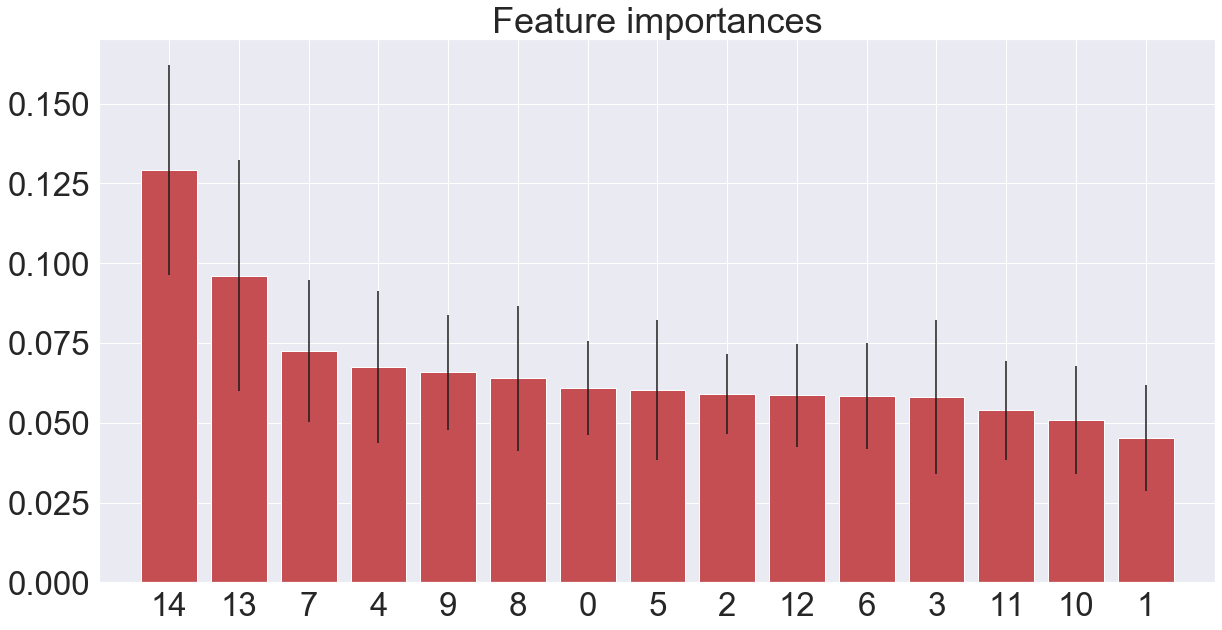

In [90]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)


# importances = logmodel.coef_[0,:]
# std = importances * 0.0

#std = 0.0*logmodel.coef_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [255]:
# filename = 'model_jan30.sav'
# pickle.dump( logmodel, open(filename,'wb') )

In [320]:
df_tmp.keys()

Index(['shift_win_rate_0', 'shift_win_rate_1', 'fav_win', 't_0_p_0_rating',
       't_0_p_0_kast', 't_0_p_0_kpr', 't_0_p_1_rating', 't_0_p_1_kast',
       't_0_p_1_kpr', 't_0_p_2_rating', 't_0_p_2_kast', 't_0_p_2_kpr',
       't_0_p_3_rating', 't_0_p_3_kast', 't_0_p_3_kpr', 't_0_p_4_rating',
       't_0_p_4_kast', 't_0_p_4_kpr', 't_1_p_0_rating', 't_1_p_0_kast',
       't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
       't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
       't_1_p_4_kpr', 'rating_dif', 'prize_rating_dif'],
      dtype='object')

# Neural Network

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [7]:
dataset = df_tmp.values
X = dataset[:,0:15].astype(float)
Y = dataset[:,15]

Y

array([-0.09026727, -0.09026727,  0.11393453,  0.11393453,  0.11393453,
        0.19134611,  0.19134611,  0.04439142,  0.0380964 ,  0.07385725,
        0.07385725,  0.06265828,  0.22443767, -0.01263414,  0.27275527,
        0.10633955,  0.03904175,  0.00755041,  0.22443767,  0.06265828,
        0.03904175,  0.27275527,  0.00755041,  0.10633955, -0.01263414,
       -0.01263414,  0.03904175,  0.00755041,  0.00679772, -0.06399944,
        0.04151988,  0.05497426,  0.04151988,  0.06271641,  0.05497426,
        0.00679772,  0.00749228, -0.06399944,  0.06271641, -0.06399944,
        0.06271641,  0.00749228, -0.07198235, -0.07198235,  0.0476936 ,
        0.05564811,  0.05564811,  0.05895028,  0.05895028,  0.1239019 ,
        0.08902069,  0.12786657,  0.02551194,  0.02551194,  0.12786657,
        0.1239019 ,  0.08902069,  0.02551194, -0.07474065,  0.08902069,
       -0.07474065, -0.07474065,  0.04779853,  0.04779853,  0.04779853,
        0.18333207,  0.18333207,  0.09966728,  0.09966728, -0.01

In [45]:
# Re-order columns
time_1 = datetime.now()

df_tmp.keys()
df_tmp = df_tmp[['shift_win_rate_0', 'shift_win_rate_1', 't_0_p_0_rating',
       't_0_p_1_rating', 't_0_p_2_rating', 't_0_p_3_rating', 't_0_p_4_rating',
       't_0_avg_rating', 't_1_p_0_rating', 't_1_p_1_rating', 't_1_p_2_rating',
       't_1_p_3_rating', 't_1_p_4_rating', 'rating_dif', 'prize_rating_dif','fav_win']]

# split into input (X) and output (Y) variables
n_input = 15

n_test = 10466

n_splits = 10  # Default 10
n_epochs = 100 # Default 100
n_batch  = 5   # Default 5

dataset = df_tmp.values
X = dataset[0:n_test,0:15].astype(float)
Y = dataset[0:n_test,15]

encoded_Y = Y

# encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
# with tf.device('/device:GPU:0'):

# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(n_input, input_dim=n_input, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate model with standardized dataset

estimator = KerasClassifier(build_fn=create_baseline, epochs=n_epochs, batch_size=n_batch, verbose=0)
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

time_2 = datetime.now()

print( time_2-time_1 )

Baseline: 63.17% (0.96%)
1:44:31.204500


In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} ) 
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4615398928002795575
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14246690300241213537
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2086928384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8290411915781283494
physical_device_desc: "device: 0, name: GeForce GTX 780, pci bus id: 0000:02:00.0, compute capability: 3.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3175781514063843211
physical_device_desc: "device: XLA_GPU device"
]


In [38]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

import keras

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

RuntimeError: `set_session` is not available when using TensorFlow 2.0.